## Import

In [1]:
# importing the libraries
import pandas as pd
import numpy as np
import os
import seaborn as sns
from itertools import chain

# for reading and displaying images
# from skimage.io import imread
import matplotlib.pyplot as plt
from glob import glob

# for creating validation set
from sklearn.model_selection import train_test_split

# PyTorch libraries and modules
import torch
import torch.nn as nn
import torch.nn.functional as F

# models
from src.architectures.resnet import *
from src.architectures.levakov_96 import *
from src.architectures.inception import *
from src.architectures.dinsdale import *

from src.run import *

from torch.optim import *
import torch.optim as optim
from torchsummary import summary
from tensorboardX import SummaryWriter

## Dataloader
for kFold, it will be run again on the run

In [2]:
from src.dataloader import *

train_dset = MyDataset(task_type='age')
test_dset = MyDataset(task_type='age', test=True)

train_loader = DataLoader(train_dset, batch_size=8)
test_loader = DataLoader(test_dset, batch_size=8)

## Load Model

In [3]:
def load_model(model, verbose=True):
    
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print(f'Model {model.capitalize()} is selected.')

    if model == 'resnet':
        

        opt = Option()
        model = generate_model(model_depth=opt.model_depth,
                                    n_classes=opt.n_classes,
                                    n_input_channels=opt.n_input_channels,
                                    shortcut_type=opt.shortcut_type,
                                    conv1_t_size=opt.conv1_t_size,
                                    conv1_t_stride=opt.conv1_t_stride,
                                    no_max_pool=opt.no_max_pool,
                                    widen_factor=opt.resnet_widen_factor)

    elif model == 'levakov':
        model = Levakov(task_type='age')

    elif model == 'inception':
        model = Inception3()

    elif model == 'dinsdale':
        model = Dinsdale(1, 1, 2)

    else: return None

    model.to(device)
    if verbose:
        print(summary(model, input_size=(1, 96, 96, 96)))
    
    return model, device

model = 'resnet'
# model, device = load_model('dinsdale')

## Setups

Default Settings

In [4]:
task_type = 'age' # no longer used.
resize = True
scheduler = False
epochs = range(100)
folds = range(10)

Loss & Optimizer

In [5]:
from src.losses import RMSELoss

loss_fn = nn.MSELoss()
lamb = 0.0005
# optimizer = optim.Adam(model.parameters(), lr=1e-4)

Metrics

In [6]:
rmse_fn = RMSELoss()
mae_fn = nn.L1Loss()

## Run

### kFold Run

Model Resnet is selected.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1       [-1, 16, 96, 48, 48]           2,352
       BatchNorm3d-2       [-1, 16, 96, 48, 48]              32
              ReLU-3       [-1, 16, 96, 48, 48]               0
         MaxPool3d-4       [-1, 16, 48, 24, 24]               0
            Conv3d-5       [-1, 16, 48, 24, 24]           6,912
       BatchNorm3d-6       [-1, 16, 48, 24, 24]              32
              ReLU-7       [-1, 16, 48, 24, 24]               0
            Conv3d-8       [-1, 16, 48, 24, 24]           6,912
       BatchNorm3d-9       [-1, 16, 48, 24, 24]              32
             ReLU-10       [-1, 16, 48, 24, 24]               0
       BasicBlock-11       [-1, 16, 48, 24, 24]               0
           Conv3d-12       [-1, 32, 24, 12, 12]          13,824
      BatchNorm3d-13       [-1, 32, 24, 12, 12]              64
             

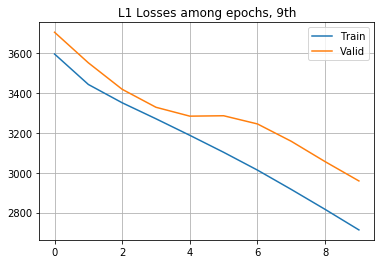

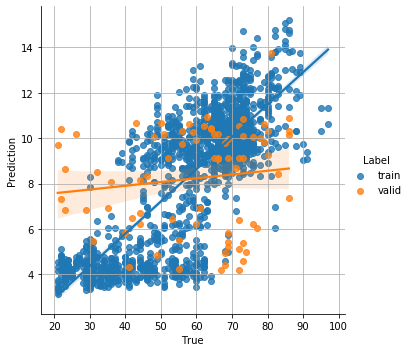

FOLD 0 - EPOCHS 10
MAE  :: [TRAIN] 49.163   | [VALID] 50.447
MSE  :: [TRAIN] 2607.892 | [VALID] 2821.249
RMSE :: [TRAIN] 50.920  | [VALID] 53.042
CORR :: [TRAIN] 0.804 | [VALID] 0.409
FOLD 0 - EPOCHS 11
MAE  :: [TRAIN] 48.135   | [VALID] 49.208
FOLD 0 - EPOCHS 12
MAE  :: [TRAIN] 47.078   | [VALID] 47.530
FOLD 0 - EPOCHS 13
MAE  :: [TRAIN] 45.965   | [VALID] 46.160
FOLD 0 - EPOCHS 14
MAE  :: [TRAIN] 44.816   | [VALID] 45.106
FOLD 0 - EPOCHS 15
MAE  :: [TRAIN] 43.629   | [VALID] 42.812
MSE  :: [TRAIN] 2038.594 | [VALID] 2067.375
RMSE :: [TRAIN] 44.980  | [VALID] 45.425
CORR :: [TRAIN] 0.892 | [VALID] 0.740
FOLD 0 - EPOCHS 16
MAE  :: [TRAIN] 42.396   | [VALID] 38.996
FOLD 0 - EPOCHS 17
MAE  :: [TRAIN] 41.147   | [VALID] 37.780
FOLD 0 - EPOCHS 18
MAE  :: [TRAIN] 39.864   | [VALID] 38.470
FOLD 0 - EPOCHS 19
MAE  :: [TRAIN] 38.593   | [VALID] 39.862


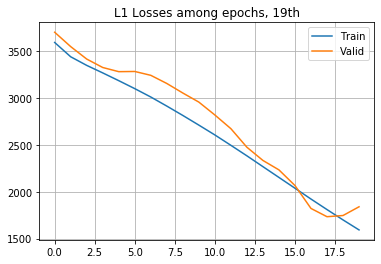

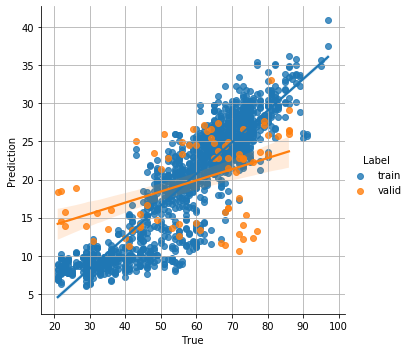

FOLD 0 - EPOCHS 20
MAE  :: [TRAIN] 37.313   | [VALID] 37.449
MSE  :: [TRAIN] 1487.667 | [VALID] 1578.401
RMSE :: [TRAIN] 38.366  | [VALID] 39.615
CORR :: [TRAIN] 0.910 | [VALID] 0.722
FOLD 0 - EPOCHS 21
MAE  :: [TRAIN] 36.004   | [VALID] 36.979
FOLD 0 - EPOCHS 22
MAE  :: [TRAIN] 34.736   | [VALID] 32.251
FOLD 0 - EPOCHS 23
MAE  :: [TRAIN] 33.379   | [VALID] 35.442
FOLD 0 - EPOCHS 24
MAE  :: [TRAIN] 31.995   | [VALID] 32.443
FOLD 0 - EPOCHS 25
MAE  :: [TRAIN] 30.659   | [VALID] 29.865
MSE  :: [TRAIN] 1005.844 | [VALID] 1031.039
RMSE :: [TRAIN] 31.464  | [VALID] 32.035
CORR :: [TRAIN] 0.927 | [VALID] 0.770
FOLD 0 - EPOCHS 26
MAE  :: [TRAIN] 29.278   | [VALID] 35.101
FOLD 0 - EPOCHS 27
MAE  :: [TRAIN] 28.025   | [VALID] 32.316
FOLD 0 - EPOCHS 28
MAE  :: [TRAIN] 26.746   | [VALID] 29.333
FOLD 0 - EPOCHS 29
MAE  :: [TRAIN] 25.485   | [VALID] 28.749


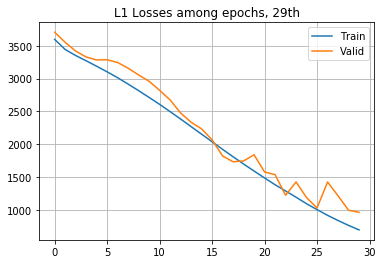

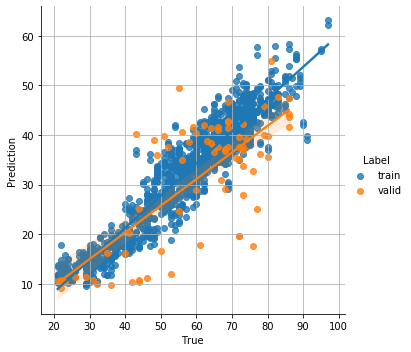

FOLD 0 - EPOCHS 30
MAE  :: [TRAIN] 24.261   | [VALID] 27.591
MSE  :: [TRAIN] 632.903 | [VALID] 895.344
RMSE :: [TRAIN] 24.838  | [VALID] 29.771
CORR :: [TRAIN] 0.947 | [VALID] 0.755
FOLD 0 - EPOCHS 31
MAE  :: [TRAIN] 23.026   | [VALID] 24.501
FOLD 0 - EPOCHS 32
MAE  :: [TRAIN] 21.777   | [VALID] 22.228
FOLD 0 - EPOCHS 33
MAE  :: [TRAIN] 20.561   | [VALID] 22.424
FOLD 0 - EPOCHS 34
MAE  :: [TRAIN] 19.359   | [VALID] 20.385
FOLD 0 - EPOCHS 35
MAE  :: [TRAIN] 18.173   | [VALID] 17.706
MSE  :: [TRAIN] 361.563 | [VALID] 411.671
RMSE :: [TRAIN] 18.580  | [VALID] 20.203
CORR :: [TRAIN] 0.956 | [VALID] 0.813
FOLD 0 - EPOCHS 36
MAE  :: [TRAIN] 17.023   | [VALID] 19.028
FOLD 0 - EPOCHS 37
MAE  :: [TRAIN] 15.889   | [VALID] 18.614
FOLD 0 - EPOCHS 38
MAE  :: [TRAIN] 14.774   | [VALID] 15.609
FOLD 0 - EPOCHS 39
MAE  :: [TRAIN] 13.715   | [VALID] 18.695


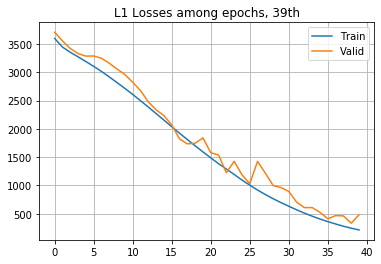

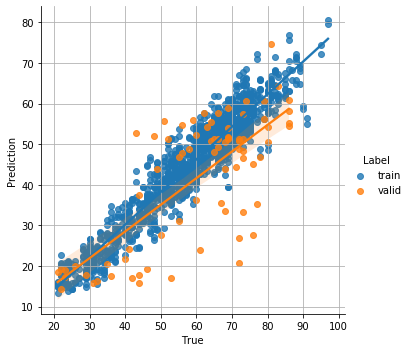

FOLD 0 - EPOCHS 40
MAE  :: [TRAIN] 12.673   | [VALID] 22.121
MSE  :: [TRAIN] 188.030 | [VALID] 698.117
RMSE :: [TRAIN] 13.127  | [VALID] 26.169
CORR :: [TRAIN] 0.953 | [VALID] 0.473
FOLD 0 - EPOCHS 41
MAE  :: [TRAIN] 11.673   | [VALID] 22.509
FOLD 0 - EPOCHS 42
MAE  :: [TRAIN] 10.750   | [VALID] 14.615
FOLD 0 - EPOCHS 43
MAE  :: [TRAIN] 9.869   | [VALID] 12.751
FOLD 0 - EPOCHS 44
MAE  :: [TRAIN] 9.048   | [VALID] 11.771
FOLD 0 - EPOCHS 45
MAE  :: [TRAIN] 8.228   | [VALID] 12.254
MSE  :: [TRAIN] 90.045 | [VALID] 199.583
RMSE :: [TRAIN] 8.689  | [VALID] 14.101
CORR :: [TRAIN] 0.954 | [VALID] 0.725
FOLD 0 - EPOCHS 46
MAE  :: [TRAIN] 7.599   | [VALID] 13.676
FOLD 0 - EPOCHS 47
MAE  :: [TRAIN] 6.900   | [VALID] 14.806
FOLD 0 - EPOCHS 48
MAE  :: [TRAIN] 6.255   | [VALID] 17.462
FOLD 0 - EPOCHS 49
MAE  :: [TRAIN] 5.718   | [VALID] 14.291


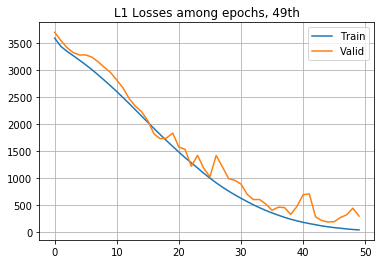

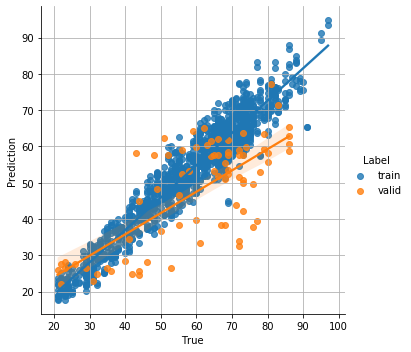

FOLD 0 - EPOCHS 50
MAE  :: [TRAIN] 5.336   | [VALID] 10.849
MSE  :: [TRAIN] 42.008 | [VALID] 167.861
RMSE :: [TRAIN] 5.644  | [VALID] 12.873
CORR :: [TRAIN] 0.961 | [VALID] 0.773
FOLD 0 - EPOCHS 51
MAE  :: [TRAIN] 5.016   | [VALID] 11.054
FOLD 0 - EPOCHS 52
MAE  :: [TRAIN] 4.865   | [VALID] 11.834
FOLD 0 - EPOCHS 53
MAE  :: [TRAIN] 4.688   | [VALID] 9.327
FOLD 0 - EPOCHS 54
MAE  :: [TRAIN] 4.612   | [VALID] 9.413
FOLD 0 - EPOCHS 55
MAE  :: [TRAIN] 4.400   | [VALID] 11.587
MSE  :: [TRAIN] 30.439 | [VALID] 205.508
RMSE :: [TRAIN] 4.982  | [VALID] 14.108
CORR :: [TRAIN] 0.953 | [VALID] 0.772
FOLD 0 - EPOCHS 56
MAE  :: [TRAIN] 4.148   | [VALID] 10.605
FOLD 0 - EPOCHS 57
MAE  :: [TRAIN] 3.967   | [VALID] 8.861
FOLD 0 - EPOCHS 58
MAE  :: [TRAIN] 3.799   | [VALID] 8.708
FOLD 0 - EPOCHS 59
MAE  :: [TRAIN] 3.636   | [VALID] 8.821


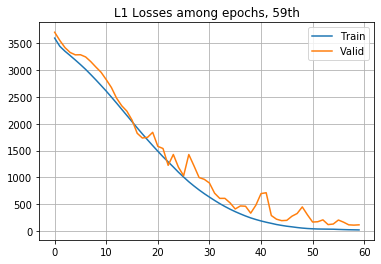

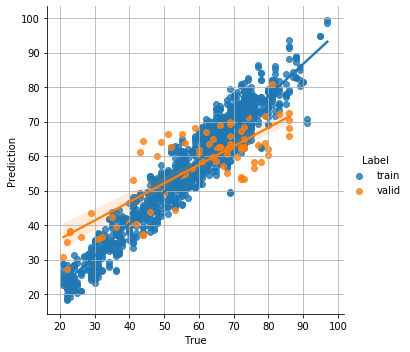

FOLD 0 - EPOCHS 60
MAE  :: [TRAIN] 3.583   | [VALID] 8.779
MSE  :: [TRAIN] 20.326 | [VALID] 114.032
RMSE :: [TRAIN] 3.900  | [VALID] 10.617
CORR :: [TRAIN] 0.963 | [VALID] 0.819
FOLD 0 - EPOCHS 61
MAE  :: [TRAIN] 3.538   | [VALID] 8.673
FOLD 0 - EPOCHS 62
MAE  :: [TRAIN] 3.588   | [VALID] 10.478
FOLD 0 - EPOCHS 63
MAE  :: [TRAIN] 3.642   | [VALID] 9.024
FOLD 0 - EPOCHS 64
MAE  :: [TRAIN] 3.666   | [VALID] 9.122
FOLD 0 - EPOCHS 65
MAE  :: [TRAIN] 3.661   | [VALID] 10.894
MSE  :: [TRAIN] 21.153 | [VALID] 178.524
RMSE :: [TRAIN] 4.097  | [VALID] 13.123
CORR :: [TRAIN] 0.961 | [VALID] 0.766
FOLD 0 - EPOCHS 66
MAE  :: [TRAIN] 3.591   | [VALID] 9.149
FOLD 0 - EPOCHS 67
MAE  :: [TRAIN] 3.638   | [VALID] 8.498
FOLD 0 - EPOCHS 68
MAE  :: [TRAIN] 3.690   | [VALID] 11.451
FOLD 0 - EPOCHS 69
MAE  :: [TRAIN] 3.630   | [VALID] 11.309


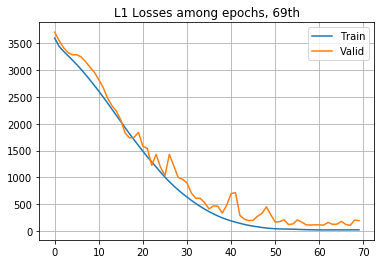

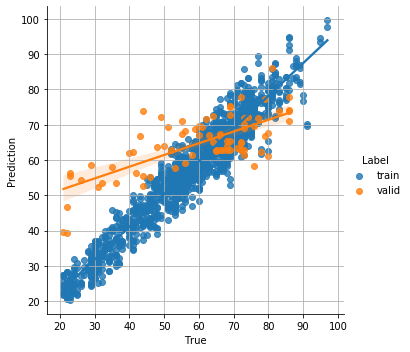

FOLD 0 - EPOCHS 70
MAE  :: [TRAIN] 3.655   | [VALID] 8.832
MSE  :: [TRAIN] 21.429 | [VALID] 112.261
RMSE :: [TRAIN] 4.128  | [VALID] 10.567
CORR :: [TRAIN] 0.960 | [VALID] 0.799
FOLD 0 - EPOCHS 71
MAE  :: [TRAIN] 3.705   | [VALID] 8.775
FOLD 0 - EPOCHS 72
MAE  :: [TRAIN] 3.711   | [VALID] 9.187
FOLD 0 - EPOCHS 73
MAE  :: [TRAIN] 3.894   | [VALID] 13.080
FOLD 0 - EPOCHS 74
MAE  :: [TRAIN] 3.993   | [VALID] 8.663
FOLD 0 - EPOCHS 75
MAE  :: [TRAIN] 3.669   | [VALID] 10.996
MSE  :: [TRAIN] 21.990 | [VALID] 184.187
RMSE :: [TRAIN] 4.244  | [VALID] 13.279
CORR :: [TRAIN] 0.960 | [VALID] 0.757
FOLD 0 - EPOCHS 76
MAE  :: [TRAIN] 3.459   | [VALID] 8.961
FOLD 0 - EPOCHS 77
MAE  :: [TRAIN] 3.356   | [VALID] 11.196
FOLD 0 - EPOCHS 78
MAE  :: [TRAIN] 3.338   | [VALID] 8.451
FOLD 0 - EPOCHS 79
MAE  :: [TRAIN] 3.204   | [VALID] 8.911


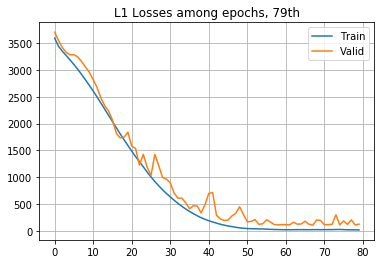

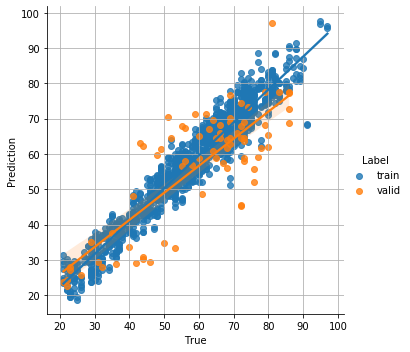

FOLD 0 - EPOCHS 80
MAE  :: [TRAIN] 3.131   | [VALID] 9.298
MSE  :: [TRAIN] 16.086 | [VALID] 133.904
RMSE :: [TRAIN] 3.494  | [VALID] 11.408
CORR :: [TRAIN] 0.970 | [VALID] 0.806
FOLD 0 - EPOCHS 81
MAE  :: [TRAIN] 3.083   | [VALID] 8.068
FOLD 0 - EPOCHS 82
MAE  :: [TRAIN] 2.994   | [VALID] 8.232
FOLD 0 - EPOCHS 83
MAE  :: [TRAIN] 3.014   | [VALID] 8.635
FOLD 0 - EPOCHS 84
MAE  :: [TRAIN] 2.843   | [VALID] 8.106
FOLD 0 - EPOCHS 85
MAE  :: [TRAIN] 2.878   | [VALID] 8.608
MSE  :: [TRAIN] 13.576 | [VALID] 112.043
RMSE :: [TRAIN] 3.306  | [VALID] 10.567
CORR :: [TRAIN] 0.974 | [VALID] 0.818
FOLD 0 - EPOCHS 86
MAE  :: [TRAIN] 2.782   | [VALID] 8.737
FOLD 0 - EPOCHS 87
MAE  :: [TRAIN] 2.789   | [VALID] 10.566
FOLD 0 - EPOCHS 88
MAE  :: [TRAIN] 2.760   | [VALID] 10.154
FOLD 0 - EPOCHS 89
MAE  :: [TRAIN] 2.626   | [VALID] 8.770


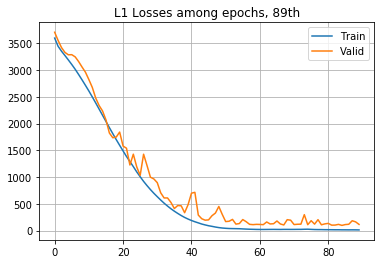

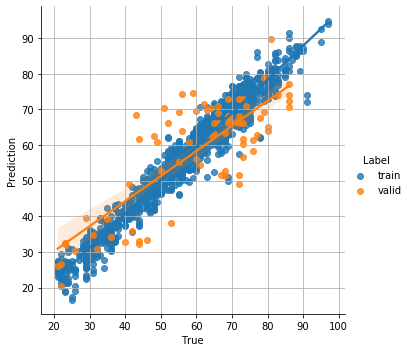

FOLD 0 - EPOCHS 90
MAE  :: [TRAIN] 2.559   | [VALID] 10.420
MSE  :: [TRAIN] 11.714 | [VALID] 176.076
RMSE :: [TRAIN] 3.105  | [VALID] 12.978
CORR :: [TRAIN] 0.978 | [VALID] 0.793
FOLD 0 - EPOCHS 91
MAE  :: [TRAIN] 2.584   | [VALID] 10.699
FOLD 0 - EPOCHS 92
MAE  :: [TRAIN] 2.528   | [VALID] 11.667
FOLD 0 - EPOCHS 93
MAE  :: [TRAIN] 2.359   | [VALID] 10.183
FOLD 0 - EPOCHS 94
MAE  :: [TRAIN] 2.165   | [VALID] 8.472
FOLD 0 - EPOCHS 95
MAE  :: [TRAIN] 2.126   | [VALID] 8.712
MSE  :: [TRAIN] 8.572 | [VALID] 113.397
RMSE :: [TRAIN] 2.669  | [VALID] 10.586
CORR :: [TRAIN] 0.984 | [VALID] 0.811
FOLD 0 - EPOCHS 96
MAE  :: [TRAIN] 2.008   | [VALID] 9.000
FOLD 0 - EPOCHS 97
MAE  :: [TRAIN] 1.829   | [VALID] 9.688
FOLD 0 - EPOCHS 98
MAE  :: [TRAIN] 1.710   | [VALID] 8.767
FOLD 0 - EPOCHS 99
MAE  :: [TRAIN] 1.651   | [VALID] 8.298


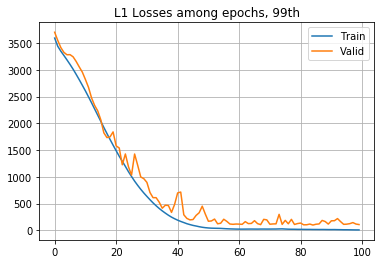

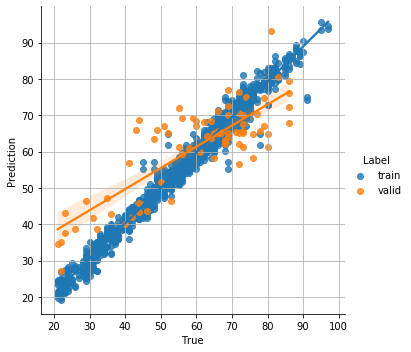

FOLD 0MSE  :: [TEST] 96.300
MAE  :: [TEST] 7.837
RMSE :: [TEST] 9.567
CORR :: [TEST] 0.793


ModuleAttributeError: 'ResNet' object has no attribute 'save'

In [7]:
best_loss = 10

trn_fold_losses, tst_fold_losses = [], []
trn_fold_corrs, tst_fold_corrs = [], []

trn_fold = {
    'MSE': list(),
    'MAE': list(),
    'RMSE': list(),
    'Correlation': list()
}

val_fold = {
    'MSE': list(),
    'MAE': list(),
    'RMSE': list(),
    'Correlation': list()
}

tst_losses, tst_maes, tst_rmses = [], [], []
for fold in folds:
    
    model_name = 'resnet'
    model, device = load_model(model_name)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    
    train_dset = MyDataset(task_type='age', fold=fold)
    valid_dset = MyDataset(task_type='age', test=True, fold=fold)
    aug_dset = MyDataset(task_type='age', augment=True, fold=fold)

    train_loader = DataLoader(train_dset, batch_size=16)
    valid_loader = DataLoader(valid_dset, batch_size=16)
    aug_loader = DataLoader(aug_dset, batch_size=16)
    
    trn_losses, val_losses = [], []
    trn_maes, val_maes = [], []
    trn_rmses, val_rmses = [], []
    
    aug_losses, aug_maes, aug_rmses = [], [], []
    
    for e in epochs:

        model, (trn_losses, trn_maes, trn_rmses), trn_preds = train(model, train_loader, resize, device,
                                                              loss_fn, mae_fn, rmse_fn,
                                                              trn_losses, trn_maes, trn_rmses,
                                                              optimizer, scheduler, lamb)
        
        model, (aug_losses, aug_maes, aug_rmses), aug_preds = train(model, aug_loader, resize, device,
                                                              loss_fn, mae_fn, rmse_fn,
                                                              aug_losses, aug_maes, aug_rmses,
                                                              optimizer, scheduler, lamb)
        
        model, (val_losses, val_maes, val_rmses), val_preds =  eval(model, valid_loader, resize, device,
                                                              loss_fn, mae_fn, rmse_fn,
                                                              val_losses, val_maes, val_rmses)


        # SUM UP RESLUTS
        trn_df = make_df(trn_preds, 'train')
        val_df = make_df(val_preds, 'valid')
        aug_df = make_df(aug_preds, 'train')
        reg_df = pd.concat([trn_df, val_df, aug_df], ignore_index=True)

        trn_corr = reg_df[reg_df['Label'] == 'train'].corr().Prediction['True']
        val_corr = reg_df[reg_df['Label'] == 'valid'].corr().Prediction['True']

        
        print(f'FOLD {fold} - EPOCHS {e}')
        print(f'MAE  :: [TRAIN] {trn_maes[-1]:.3f}   | [VALID] {val_maes[-1]:.3f}')
        if e % 5 == 0:
            print(f'MSE  :: [TRAIN] {trn_losses[-1]:.3f} | [VALID] {val_losses[-1]:.3f}')
            print(f'RMSE :: [TRAIN] {trn_rmses[-1]:.3f}  | [VALID] {val_rmses[-1]:.3f}')
            print(f'CORR :: [TRAIN] {trn_corr:.3f} | [VALID] {val_corr:.3f}')

        if e % 10 == 9:
            plt.title(f"L1 Losses among epochs, {e}th")
            plt.plot(trn_losses, label='Train')
            plt.plot(val_losses, label='Valid')
            plt.grid(); plt.legend()
            
            sns.lmplot(data=reg_df, x='True', y='Prediction', hue='Label')
            plt.grid()
            plt.show()
    
    torch.save(model, f'./models/{model_name}_1222_{fold}_{e}_{trn_losses[-1]}.pth')
    
    trn_fold['MSE'].append(trn_losses)
    trn_fold['MAE'].append(trn_maes)
    trn_fold['RMSE'].append(trn_rmses)
    trn_fold['Correlation'].append(trn_corr)
    
    val_fold['MSE'].append(val_losses)
    val_fold['MAE'].append(val_maes)
    val_fold['RMSE'].append(val_rmses)
    val_fold['Correlation'].append(val_corr)
    
    # TEST
    test_dset = MyDataset(task_type='age', test=True)
    test_loader = DataLoader(test_dset, batch_size=8)
    
    model, (tst_losses, tst_maes, tst_rmses), tst_preds = eval(model, test_loader, resize, device,
                                                              loss_fn, mae_fn, rmse_fn,
                                                              tst_losses, tst_maes, tst_rmses)

    tst_df = make_df(tst_preds, 'test')
    reg_df = pd.concat([reg_df, tst_df], ignore_index=True)

    tst_corr = reg_df[reg_df['Label'] == 'test'].corr().Prediction['True']
    
    print(f'FOLD {fold}', end='')
    print(f'MSE  :: [TEST] {tst_losses[-1]:.3f}')
    print(f'MAE  :: [TEST] {tst_maes[-1]:.3f}')
    print(f'RMSE :: [TEST] {tst_rmses[-1]:.3f}')
    print(f'CORR :: [TEST] {tst_corr:.3f}')
    
    torch.save(model, f'./models/{model_name}_{tst_maes[-1]}.pth')

    sns_plot = sns.lmplot(data=reg_df, x='True', y='Prediction', hue='Label')
    sns_plot.savefig(f'{fold}.png')
    plt.grid()
    plt.show()
    
    del model
    torch.cuda.empty_cache()

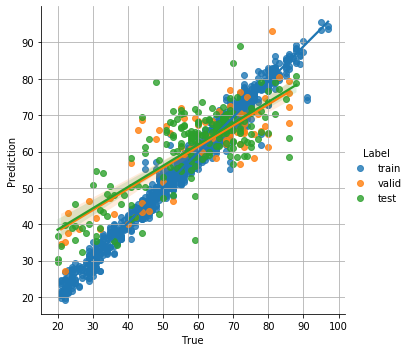

In [8]:
    sns_plot = sns.lmplot(data=reg_df, x='True', y='Prediction', hue='Label')
    sns_plot.savefig(f'{fold}.png')
    plt.grid()
    plt.show()

In [12]:
model

ResNet(
  (conv1): Conv3d(1, 16, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3), bias=False)
  (bn1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool3d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn2): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (layer2): Sequential(
    (0): BasicBlock(
      (conv1): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
      (bn1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=Tru

In [14]:
# torch.save(model, 'model.pth')
# model= torch.load('model_scale.pth')

import nibabel as nib
from utils.guided_backprop import GuidedBackprop

_ = model.eval()

# Remove LogSoftmax
model.layer4 = nn.Sequential(*list(model.layer4.children())[:-1])

GBP = GuidedBackprop(model)

inputs, label = x.permute(3, 0, 1, 2), torch.BoolTensor(0)
input_img = nn.Parameter(torch.FloatTensor(inputs).unsqueeze(0), requires_grad=True).to(device)

guided_grads = GBP.generate_gradients(input_img, label)

export_gradient = np.zeros((3,75,93,81))
export_gradient[:, 8:-8, 8:-8, :-10] = guided_grads
nifti_img = nib.Nifti1Image(export_gradient.transpose(1, 2, 3, 0), np.eye(4))
nifti_img = nib.Nifti1Image(guided_grads.transpose(1, 2, 3, 0), np.eye(4))
nifti_img.to_filename('vis_tmp.nii.gz')

nib.load('vis_tmp.nii.gz').get_data()[[nib.load('vis_tmp.nii.gz').get_fdata() != 0]]

ModuleAttributeError: 'ResNet' object has no attribute 'preBlock'

In [ ]:
# best_loss = 10

# trn_fold_losses, tst_fold_losses = [], []
# trn_fold_corrs, tst_fold_corrs = [], []

# trn_fold = {
#     'MSE': list(),
#     'MAE': list(),
#     'RMSE': list(),
#     'Correlation': list()
# }

# tst_fold = {
#     'MSE': list(),
#     'MAE': list(),
#     'RMSE': list(),
#     'Correlation': list()
# }

# for fold in folds:
    
#     train_dset = MyDataset(task_type='age', fold=fold)
#     test_dset = MyDataset(task_type='age', test=True, fold=fold)

#     train_loader = DataLoader(train_dset, batch_size=8)
#     test_loader = DataLoader(test_dset, batch_size=8)
    
#     trn_losses, tst_losses = [], []
#     trn_maes, tst_maes = [], []
#     trn_rmses, tst_rmses = [], []
#     for e in epochs:

#         # TRAIN
#         trn_bth_loss, trn_bth_mae, trn_bth_rmse = 0, 0, 0
#         trn_trues, trn_preds = [], []
#         model.train()
#         for i, (x, y) in enumerate(train_loader):

#             if resize:
#                 x, y = F.interpolate(x, size=(96, 96, 96)).to(device), y.to(device)

#             else:
#                 x, y = x.to(device), y.to(device)

#             optimizer.zero_grad()

#             y_pred = model.forward(x).to(device)

#             trn_trues.append(y.to('cpu'))
#             trn_preds.append(y_pred.to('cpu'))

#             # Loss
#             loss = loss_fn(y_pred.squeeze(1), y)
            
#             # Metrics
#             mae = mae_fn(y_pred.squeeze(1), y)
#             rmse = rmse_fn(y_pred.squeeze(1), y)
            
#             del x, y, y_pred

#             loss.backward()
#             optimizer.step()
#             if scheduler: scheduler.step()

#             trn_bth_loss += loss.item()
#             trn_bth_mae  += loss.item()
#             trn_bth_rmse += loss.item()

#         torch.cuda.empty_cache()

#         ### loss
#         trn_losses.append(trn_bth_loss / len(train_loader))
#         trn_maes.append(trn_bth_mae / len(train_loader))
#         trn_rmses.append(trn_bth_rmse / len(train_loader))

#         ### collect trues/predictions
#         trn_trues = list(chain(*trn_trues))
#         trn_preds = list(chain(*trn_preds))

        
#         # VALID
#         tst_bth_loss, tst_bth_mae, tst_bth_rmse = 0, 0, 0
#         model.eval()
#         tst_trues, tst_preds = [], []
#         with torch.no_grad(): # to not give loads on GPU... :(
#             for i, (x, y) in enumerate(test_loader):
#                 if resize:
#                     x, y = F.interpolate(x, size=(96, 96, 96)).to(device), y.to(device)

#                 else:
#                     x, y = x.to(device), y.to(device)

#                 y_pred = model.forward(x).to(device)

#                 tst_trues.append(y.to('cpu'))
#                 tst_preds.append(y_pred.to('cpu'))

#                 # Loss
#                 loss = loss_fn(y_pred.squeeze(1), y)
                
#                 # Metrics
#                 mae = mae_fn(y_pred.squeeze(1), y)
#                 rmse = rmse_fn(y_pred.squeeze(1), y)
                
#                 del x, y, y_pred

#                 tst_bth_loss += loss.item()
#                 tst_bth_mae  += loss.item()
#                 tst_bth_rmse += loss.item()
                
#         torch.cuda.empty_cache()
        
#         ### loss
#         tst_losses.append(tst_bth_loss / len(test_loader))
#         tst_maes.append(tst_bth_mae / len(test_loader))
#         tst_rmses.append(tst_bth_rmse / len(test_loader))

#         ### collect trues/predictions
#         tst_trues = list(chain(*tst_trues))
#         tst_preds = list(chain(*tst_preds))

        
#         # SUM UP RESLUTS
#         reg_df = pd.DataFrame({
#             'True': list(map(float, trn_trues + tst_trues)),
#             'Prediction': list(map(float, trn_preds + tst_preds)),
#             'Label': ['train'] * len(trn_trues) + ['valid'] * len(tst_trues)
#         })

#         trn_corr = reg_df[reg_df['Label'] == 'train'].corr().Prediction['True']
#         tst_corr = reg_df[reg_df['Label'] == 'valid'].corr().Prediction['True']

#         if e % 5 == 0:
#             print(f'FOLD {fold} - EPOCHS {e}')
#             print(f'MSE  :: [TRAIN] {trn_losses[-1]:.3f} | [VALID] {tst_losses[-1]:.3f}')
#             print(f'MAE  :: [TRAIN] {trn_maes[-1]:.3f}   | [VALID] {tst_maes[-1]:.3f}')
#             print(f'RMSE :: [TRAIN] {trn_rmses[-1]:.3f}  | [VALID] {tst_rmses[-1]:.3f}')
#             print(f'CORR :: [TRAIN] {trn_corr:.3f} | [VALID] {tst_corr:.3f}')

#         if e % 10 == 9:
#             plt.title(f"L1 Losses among epochs, {e}th")
#             plt.plot(trn_losses, label='Train')
#             plt.plot(tst_losses, label='Valid')
#             plt.grid(); plt.legend()
            
#             sns.lmplot(data=reg_df, x='True', y='Prediction', hue='Label')
#             plt.grid()
#             plt.show()
    
#     trn_fold['MSE'].append(trn_losses)
#     trn_fold['MAE'].append(trn_maes)
#     trn_fold['RMSE'].append(trn_rmses)
#     trn_fold['Correlation'].append(trn_corr)
    
#     tst_fold['MSE'].append(tst_losses)
#     tst_fold['MAE'].append(tst_maes)
#     tst_fold['RMSE'].append(tst_rmses)
#     tst_fold['Correlation'].append(tst_corr)
    
#     # TEST
#     test_dset = MyDataset(task_type='age', test=True)
#     test_loader = DataLoader(test_dset, batch_size=8)
    
#     tst_bth_loss = 0
#     model.eval()
#     tst_trues, tst_preds = [], []
#     with torch.no_grad(): # to not give loads on GPU... :(
#         for i, (x, y) in enumerate(test_loader):
#             if resize:
#                 x, y = F.interpolate(x, size=(96, 96, 96)).to(device), y.to(device)

#             else:
#                 x, y = x.to(device), y.to(device)

#             y_pred = model.forward(x).to(device)

#             tst_trues.append(y.to('cpu'))
#             tst_preds.append(y_pred.to('cpu'))

#             loss = loss_fn(y_pred.squeeze(1), y)
            
#             mae = mae_fn(y_pred.squeeze(1), y)
#             rmse = rmse_fn(y_pred.squeeze(1), y)
#             del x, y, y_pred

#             tst_bth_loss += loss.item()

#     torch.cuda.empty_cache()
#     ### loss
#     tst_loss = tst_bth_loss / len(test_loader)

#     ### collect trues/predictions
#     tst_trues = list(chain(*tst_trues))
#     tst_preds = list(chain(*tst_preds))
    
#     tst_df = pd.DataFrame({
#         'True': list(map(float, tst_trues)),
#         'Prediction': list(map(float, tst_preds)),
#         'Label': ['test'] * len(tst_trues)
#     })
#     reg_df = pd.concat([reg_df, tst_df], ignore_index=True)

#     tst_corr = reg_df[reg_df['Label'] == 'test'].corr().Prediction['True']
#     print(f'FOLD {fold}', end='')
#     print(f'RMSE :: [TEST] {tst_loss:.3f}')
#     print(f'CORR :: [TEST] {tst_corr:.3f}')

#     sns.lmplot(data=reg_df, x='True', y='Prediction', hue='Label')
#     plt.grid()
#     plt.show()